In [1]:
import os
import librosa #audio-processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #audio-processing
import warnings
warnings.filterwarnings("ignore")

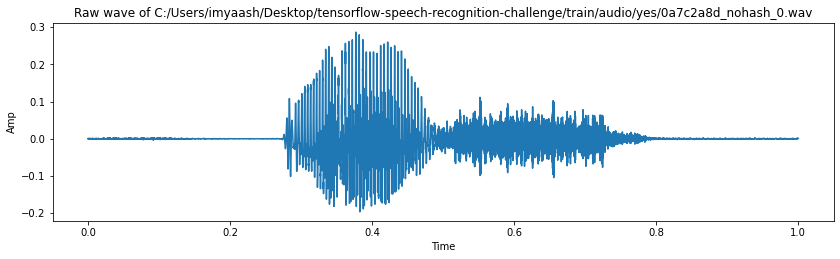

In [2]:
##Eploration

training_audio = 'C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio/'
samples, samplerate = librosa.load(training_audio+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
figure = plt.figure(figsize=(14, 8))
ax1 = figure.add_subplot(211)
ax1.set_title('Raw wave of ' + 'C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amp')
ax1.plot(np.linspace(0, samplerate/len(samples), samplerate), samples)

In [3]:
##Sampling Rate
ipd.Audio(samples, rate=samplerate)
print(samplerate)

16000


In [4]:
##ReSampling
resample = librosa.resample(samples, samplerate, 8000)
ipd.Audio(resample, rate = 8000)

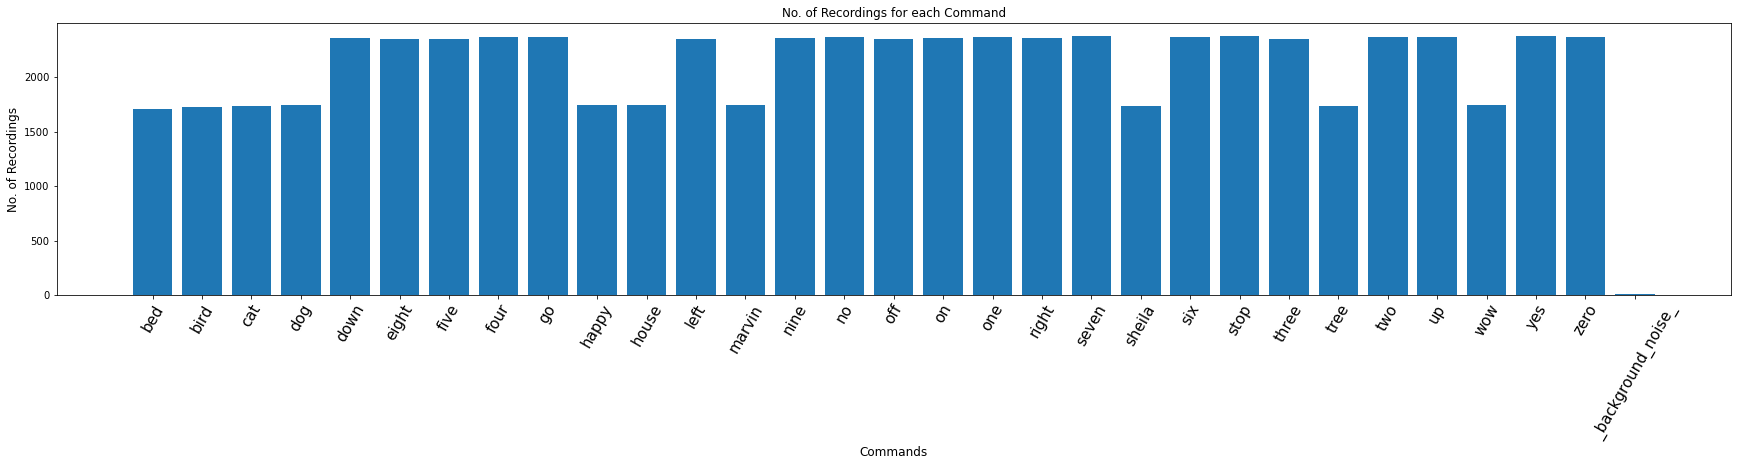

In [5]:
labels = os.listdir('C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio')

##find count of each label and plot bar-graph
noofrecordings = []
for label in labels:
    waves = [f for f in os.listdir('C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio' + '/' + label) if f.endswith('.wav')]
    noofrecordings.append(len(waves))

#plot
plt.figure(figsize = (30,5))
index = np.arange(len(labels))
plt.bar(index, noofrecordings)
plt.xlabel('Commands', fontsize = 12)
plt.ylabel('No. of Recordings', fontsize = 12)
plt.xticks(index, labels, fontsize = 15, rotation = 60)
plt.title('No. of Recordings for each Command')
plt.show()

labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

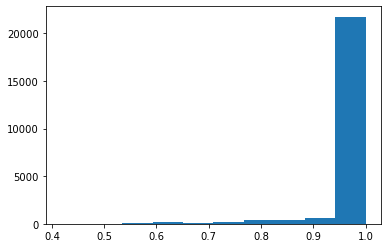

In [6]:
duration = []
for label in labels:
    waves = [f for f in os.listdir('C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio' + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        samplerate, samples = wavfile.read('C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio' + '/' + label + '/' + wav)
        duration.append(float(len(samples)/samplerate))
        
plt.hist(np.array(duration))

In [7]:
trainingaudiopath = 'C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/train/audio'

allwave = []
alllabel = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(trainingaudiopath + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        samples, samplerate = librosa.load(trainingaudiopath + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, samplerate, 8000)
        if(len(samples) == 8000):
            allwave.append(samples)
            alllabel.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [8]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y = LE.fit_transform(alllabel)
classes = list(LE.classes_)

In [9]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes = len(labels))

In [10]:
allwave = np.array(allwave).reshape(-1,8000,1)

In [11]:
from sklearn.model_selection import train_test_split
xtr, xval, ytr, yval = train_test_split(np.array(allwave), np.array(y), stratify = y, test_size = 0.2, random_state = 777, shuffle = True)

In [12]:
####Model Building####
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as BE
BE.clear_session()

inputs = Input(shape = (8000, 1))

##First Conv1D layer
conv = Conv1D(8, 13, padding = 'valid', activation = 'relu', strides = 1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

##Second Conv1D layer
conv = Conv1D(16, 11, padding = 'valid', activation = 'relu', strides = 1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

##Thrid Conv1D layer
conv = Conv1D(32, 9, padding = 'valid', activation = 'relu', strides = 1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

##Fourth Conv1D layer
conv = Conv1D(64, 7, padding = 'valid', activation = 'relu', strides = 1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

##Flatten layer
conv = Flatten()(conv)

##Dense Layer 1
conv = Dense(256, activation = 'relu')(conv)
conv = Dropout(0.3)(conv)

##Dense Layer 2
conv = Dense(128, activation = 'relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation = 'softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
earlystop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, min_delta = 0.0001)
modelcheck = ModelCheckpoint('best_model.hdf5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [15]:
history = model.fit(xtr, ytr, epochs = 100, callbacks = [earlystop, modelcheck], batch_size = 32, validation_data = (xval, yval))

Epoch 1/100
533/533 [==============================] - 61s 112ms/step - loss: 2.1991 - accuracy: 0.1618 - val_loss: 1.6069 - val_accuracy: 0.4274
Epoch 2/100
533/533 [==============================] - 59s 111ms/step - loss: 1.4040 - accuracy: 0.4896 - val_loss: 1.1149 - val_accuracy: 0.6101
Epoch 3/100
533/533 [==============================] - 60s 113ms/step - loss: 1.0629 - accuracy: 0.6242 - val_loss: 0.8628 - val_accuracy: 0.6972
Epoch 4/100
533/533 [==============================] - 60s 113ms/step - loss: 0.8968 - accuracy: 0.6807 - val_loss: 0.7474 - val_accuracy: 0.7457
Epoch 5/100
533/533 [==============================] - 61s 114ms/step - loss: 0.7963 - accuracy: 0.7197 - val_loss: 0.6831 - val_accuracy: 0.7657
Epoch 6/100
533/533 [==============================] - 61s 115ms/step - loss: 0.7207 - accuracy: 0.7501 - val_loss: 0.6801 - val_accuracy: 0.7725
Epoch 7/100
533/533 [==============================] - 62s 116ms/step - loss: 0.6589 - accuracy: 0.7686 - val_loss: 0.6077 -

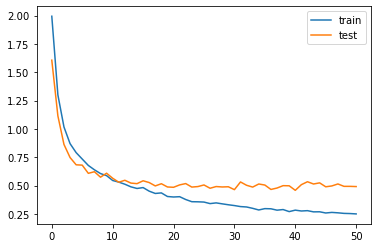

In [16]:
##Diagnostic Plots##
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'test')
pyplot.legend()
pyplot.show()

In [21]:
from keras.models import load_model
model = load_model('bestmodel.hdf5')

In [22]:
def predict(audio):
    prob = model.predict(audio.reshape(1, 8000, 1))
    index = np.argmax(prob[0])
    return classes[index]

In [23]:
import random
index = random.randint(0, len(xval)-1)
samples = xval[index].ravel()
print ("Audio:", classes[np.argmax(yval[index])])
ipd.Audio(samples, rate = 8000)
print("Text:", predict(samples))

Audio: up
Text: up


In [25]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000
duration = 1 #seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate = samplerate,
    channels = 1, blocking = True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [27]:
os.listdir('C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/Voice Test')
filepath = 'C:/Users/imyaash/Desktop/tensorflow-speech-recognition-challenge/Voice Test'

##Reading Vioce Test Files
samples, samplerate = librosa.load(filepath + '/' + 'Voice Test Recording.wav', sr = 16000)
samples = librosa.resample(samples, samplerate, 8000)
ipd.Audio(samples, rate = 8000)

predict(samples)

ValueError: cannot reshape array of size 19627 into shape (1,8000,1)